# Studienarbeit: Uncertainty modelling of static laser scanning using Pointnet

##  Imports and settings

In [2]:
#Numerical, matrix operations
import numpy as np
import math

#Data read and write to make_dot
import os
import pandas as pd                                           #open source data analysis and manipulation tool
import csv

# Progress bars
from tqdm.notebook import tqdm

# Pytorch deep learning tensor manipulation framework
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
#from pointnet_utils import PointNetEncoder, feature_transform_reguliarzer
# Switch to CPU when GPU is not available.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torchmetrics.regression import R2Score

# Draw pytorch's network
#from torchviz import make_dot

# Learning curve plotting
#from torch.utils.tensorboard import SummaryWriter

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.neighbors import KDTree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#Others
import seaborn as sns
import matplotlib.pyplot as plt
from plyfile import PlyData, PlyElement
import random
#import open3d as o3d
import copy

##   Part 1: Laden des Datensatzes & Zuordnen der Features

In [3]:
f = r"C:\Studienarbeit/Code/01_3DPrint.ply"
ply = PlyData.read(f)
x = ply.elements[0].data['x']
y = ply.elements[0].data['y']
z = ply.elements[0].data['z']
Scan_ID = ply.elements[0].data["scalar_Scan_ID"]
intensity = ply.elements[0].data['scalar_intensity']
incidence = ply.elements[0].data['scalar_incidence']
spotsize = ply.elements[0].data['scalar_spotsize']
sigma_dist = ply.elements[0].data['scalar_sigma_dist']
distance = ply.elements[0].data['scalar_range_measured']
range_residual = ply.elements[0].data['scalar_range_residual']

raw_f = np.c_[intensity,incidence,sigma_dist,distance]
raw_xyz = np.c_[x,y,z]
# Hier werdeb die Residuen auf 1 cm begrenzt. Alles was darüber liegt sind höchstwahrscheinlich Ausreißer
I = np.where(np.abs(range_residual < 0.01) & (incidence > 10))#&(sigma_dist<0.0007)

raw_f = raw_f[I[0],:]
xyz = raw_xyz[I[0],:]
raw_y = range_residual[I[0]]


### Feature Transformation

In [4]:
def pc_normalize(pc):
    '''normalize the point cloud by substracting the centroid and dividing by the maximum norm'''
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
scaler = MinMaxScaler()
feature  = scaler.fit_transform(raw_f) # normalize
raw_fy =np.hstack((feature, raw_y.reshape(-1,1)))
xyz = pc_normalize(xyz)
scan_id = Scan_ID[I[0]]


##### read the file of group

In [5]:
import os

def ebene_loader(scan_id, data_path, filename_prefix): 
    '''load the point cloud of the plane'''
    filename_number = str(scan_id)
    file_path = os.path.join(data_path, f"{filename_prefix}_{filename_number}.npy")
    data = np.load(file_path)
    data = torch.from_numpy(data) 
    return data

def load_data(scan_ids, data_path, filename_prefix):
    raw_x_list = []
    for scan_idx in scan_ids:
        ebene_xyz = ebene_loader(scan_idx, data_path, filename_prefix)
        raw_x_list.append(ebene_xyz)
    raw_x = torch.cat(raw_x_list, dim=0)
    return raw_x

data_path = 'C:/Studienarbeit/Code/Pointnet/data/New/'
filename_prefix = "Group"
scan_ids = np.unique(scan_id)  # 假设scan_id已经定义
raw_x = load_data(scan_ids, data_path, filename_prefix)

#### Train datensatz & Test datensatz & Valid datensatz

In [6]:
# print(raw_x.shape)
# print(raw_fy.shape)
# raw_x = raw_x[:10000,:,:]
# raw_fy = raw_fy[:10000,:]
# print(raw_x.shape)
# print(raw_fy.shape)

In [7]:

x_rest, x_test, y_rest, y_test = train_test_split(raw_x, raw_fy,test_size=0.1,random_state=42)
#method 1 --------------------------------------------------------------------------------------
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=1) 

#method 2 KFold --------------------------------------------------------------------------------------
# from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print(x_test.shape)
print("test data ratio:",round(y_test.shape[0]/raw_fy.shape[0]*100,2),"%")



torch.Size([253158, 128, 3])
test data ratio: 10.0 %


### Dataloader 
Read data from files and set up training, validation, and testing sets. 

In [8]:
class EbeneDataset(Dataset):  #Dataset
    '''
    x: np.ndarray  特征矩阵.
    y: np.ndarray  目标标签, 如果为None,则是预测的数据集
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [9]:
def loader(x_train, y_train,x_valid, y_valid,x_test,y_test):
    
    train_dataset, valid_dataset, test_dataset = EbeneDataset(x_train, y_train),EbeneDataset(x_valid, y_valid),EbeneDataset(x_test,y_test)
    #print(train_dataset)

    # Pytoch data loader loads pytorch dataset into batchs./使用Pytorch中Dataloader类按照Batch将数据集加载
    #sheuffle: 每个 epoch 是否乱序
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    test_loader  = DataLoader(test_dataset , batch_size= 1, shuffle=False, pin_memory=True)

    return train_loader,valid_loader,test_loader

## Part 5: Deep learning Modellen 

### Transform & Transform reguliarze & PointNet

### Multi-scalegrouping $ Pointnet++
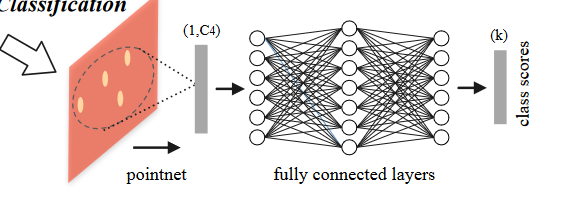

### Defining the PR_Model 

In [10]:

################
class RePN_Model(nn.Module): #Regression-PointNet
    def __init__(self,  nsample_list, mlp_list):
        super(RePN_Model, self).__init__()
        self.nsample_list = nsample_list
        self.mlp_list = mlp_list
        self.conv_blocks = nn.ModuleList() #ModuleList是一个储存各种模块的容器，可以像使用list一样使用它
        self.bn_blocks = nn.ModuleList()
        for i in range(len(mlp_list)):
            convs = nn.ModuleList()
            bns = nn.ModuleList()
            last_channel =  3
            for out_channel in mlp_list[i]:
                convs.append(nn.Conv1d(last_channel, out_channel, 1))
                bns.append(nn.BatchNorm1d(out_channel))
                last_channel = out_channel
            self.conv_blocks.append(convs)
            self.bn_blocks.append(bns)
        #print("self.conv_blocks:{}".format(self.conv_blocks))
        #print('self.bn_blocks:{}'.format(self.bn_blocks))
        self.fc1 = nn.Linear(324, 216) 
        self.fc2 = nn.Linear(216, 216)
        self.fc3 = nn.Linear(216, 110)
        self.fc4 = nn.Linear(110, 110)
        self.fc5 = nn.Linear(110, 1)
        self.noli = nn.ReLU()       #non-linearity


    def forward(self, x, f):
        xn = x.permute(0, 2, 1)  # [B, 3, K] 
        #print("x:{}".format(x))
        #print("x shape:{}".format(x.shape))
        new_points_list = []
        # Convolution input: [B, 3, K]  output: [B, 64/128/128, K]
        for i, nsample in enumerate(self.nsample_list):
            #print("i:{}".format(i))
            x = xn[:,:,:nsample]
            for j in range(len(self.conv_blocks[i])):
                #print("j:{}".format(j))
                conv = self.conv_blocks[i][j]
                #print("conv:{}".format(conv))
                bn = self.bn_blocks[i][j]
                #print("x shape:{}".format(x.shape))
                #grouped_points =  F.relu(bn(conv(x))) #卷积 B*3*K
                x = conv(x)
                x = bn(x)
                x = F.relu(x)

            new_points = torch.max(x, 2)[0]  # [B, 64/128/128] The first radius feature I*64 /The second radius feature I*128 /The third radius feature I*128
            new_points_list.append(new_points) #B*64 + B*128 + B*128    
        new_points_concat = torch.cat(new_points_list, dim=1)
        x = torch.cat([new_points_concat, f], dim=1) #B*(320+4) 
        # fully connected layer       
        x = self.fc1(x)
        x = self.noli(x)
        x = self.fc2(x)
        x = self.noli(x)
        x = self.fc3(x)
        x = self.noli(x)
        x = self.fc4(x)
        x = self.noli(x)
        x = self.fc5(x)

        return x




### Training loop

In [11]:
def trainer(train_loader, valid_loader, model, config, device, optimizer):
    
    list_mean_train_loss = []
    list_mean_valid_loss = []

    criterion = nn.MSELoss() # loss function
    #criterion = nn.CrossEntropyLoss() # loss function
    
    # Define Optimizer
    #optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) #
    
    if not os.path.isdir('./models'):
        # Create folder - for storing models
        os.mkdir('./models')

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0 #math.inf 无穷大

    for epoch in range(n_epochs):
        model.train() 
        loss_record = []
  
#train-----------------------------------------------------------------------------------------------------------
        # tqdm helps us to show the progress of our training  
        train_pbar = tqdm(train_loader, position=0, leave=True)      
        # Set the left side of the progress bar : Show the number of Epochs
        train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
        ss = 0
        for x, y in train_pbar:
 
            ss +=1
            f = y[:,:4]
            y = y[:,4]
            y = y.view(-1, 1)
            optimizer.zero_grad()               # Set the gradient to 0..
            x,  y, f = x.to(device), y.to(device),f.to(device)   # Transfer data one to the appropriate storage location (CPU/GPU)
            pred = model(x, f)      
            loss = criterion(pred, y)
            loss.backward()                     # Back propagation Calculation of gradients.
            optimizer.step()                    # Update network parameters
            step += 1
            loss_record.append(loss.detach().item())

            # After training a batch of data, show the loss on the right side of the progress bar
            #train_pbar.set_postfix({'loss': loss.detach().item()})
            if ss == 200:
               mean_train_loss = np.sqrt(np.mean(loss_record))*1000
               train_pbar.set_description('RMSE=: %f' % (mean_train_loss))
               ss = 0
               pass
            pass
        
        mean_train_loss = np.mean(loss_record)
        mean_train_loss = np.sqrt(mean_train_loss)*1000
        list_mean_train_loss.append(mean_train_loss)

#validation-------------------------------------------------------------------------------------------------------
        model.eval() # Set the model to evaluation mode.
        loss_record = []

        for x, y in valid_loader:
            f = y[:,:4]
            y = y[:,4].view(-1, 1)
            x, y, f = x.to(device), y.to(device), f.to(device)
            with torch.no_grad():
                pred = model(x, f)
                loss = criterion(pred, y)
            loss_record.append(loss.item())
            pass

        mean_valid_loss = np.mean(loss_record)
        mean_valid_loss = np.sqrt(mean_valid_loss)*1000
        list_mean_valid_loss.append(mean_valid_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.12f},\
        Valid loss: {mean_valid_loss:.12f}')

#------------------------------------------------------------------------------------------------------------------ 
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path'][k]) # Model Saving
            print('Saving model with loss {:.12f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return list_mean_train_loss, list_mean_valid_loss, best_loss
    return list_mean_train_loss, list_mean_valid_loss , best_loss


### Start training

In [12]:
def print_summary( list_mean_train_loss, list_mean_valid_los):
 
    plt.subplot(1,2,2)
    plt.plot([x for x in list_mean_train_loss], label='Training Loss')
    plt.plot([x for x in list_mean_valid_los], label='Validation Loss')
    plt.legend()
    plt.show()

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    pass

def save_pred(preds, file):
    ''' 将模型保存到指定位置'''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])
    pass

def test(test_loader, device, k, y_test_r):
    model.eval() # 设置成eval模式.
    preds = []
    #f = torch.tensor(y_test[:,:4])
    for x, y in tqdm(test_loader):
        model.load_state_dict(torch.load(config['save_path'][k]))
        f = y[:,:4]
        #print(f.shape)
        x = x.to(device)                        
        with torch.no_grad():
            pred = model(x, f)         
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()
    #y_test = torch.tensor(y_test[:,4])
    RMSE = np.sqrt(mean_squared_error(y_test_r, preds))
    R2 = r2_score(y_test_r, preds)
    print(f" Fold: {k+1}/5 R2 = {R2*100:.2f} , RMSE = {RMSE:.6f}") 
   
    return preds

In [13]:
a = [1,2,3]
b = [4,5,6]
c = [[1,2,3],[4,5,6]]   
c= list(np.mean(c,axis=0))
print(c)

[2.5, 3.5, 4.5]


Fold: 1 /5
training...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [1/20]: Train loss: 0.876188585934,        Valid loss: 0.445139575944
Saving model with loss 0.445139575944...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [2/20]: Train loss: 0.474832078487,        Valid loss: 0.418642296548
Saving model with loss 0.418642296548...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [3/20]: Train loss: 0.446158614734,        Valid loss: 0.420553034460


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [4/20]: Train loss: 0.427378777860,        Valid loss: 0.590055045947


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [5/20]: Train loss: 0.417860051548,        Valid loss: 0.454212992028


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [6/20]: Train loss: 0.412990476751,        Valid loss: 0.388108144970
Saving model with loss 0.388108144970...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [7/20]: Train loss: 0.405417126252,        Valid loss: 0.415362001480


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [8/20]: Train loss: 0.400036051159,        Valid loss: 0.384936898240
Saving model with loss 0.384936898240...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [9/20]: Train loss: 0.394920809553,        Valid loss: 0.369114331573
Saving model with loss 0.369114331573...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [10/20]: Train loss: 0.386715338205,        Valid loss: 0.360406242128
Saving model with loss 0.360406242128...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [11/20]: Train loss: 0.382355143883,        Valid loss: 0.356462042759
Saving model with loss 0.356462042759...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [12/20]: Train loss: 0.379750065132,        Valid loss: 0.404360779401


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [13/20]: Train loss: 0.376290024440,        Valid loss: 0.391617346299


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [14/20]: Train loss: 0.375393265104,        Valid loss: 0.344951643450
Saving model with loss 0.344951643450...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [15/20]: Train loss: 0.372200518400,        Valid loss: 0.382632746045


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [16/20]: Train loss: 0.371277775470,        Valid loss: 0.370891613023


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [17/20]: Train loss: 0.369210512458,        Valid loss: 0.400203960313


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [18/20]: Train loss: 0.368681158878,        Valid loss: 0.356046637453


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [19/20]: Train loss: 0.366484722812,        Valid loss: 0.365461689406


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [20/20]: Train loss: 0.366995402168,        Valid loss: 0.345225889055

Model is not improving, so we halt the training session.


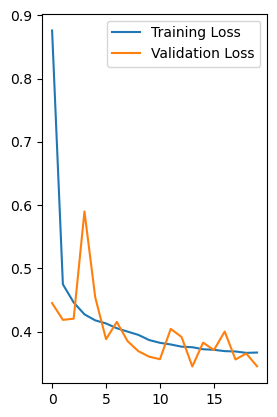

testing...


  0%|          | 0/253158 [00:00<?, ?it/s]

 Fold: 1/5 R2 = 71.03 , RMSE = 0.000344
Fold: 2 /5
training...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [1/20]: Train loss: 0.886550220200,        Valid loss: 0.501098546286
Saving model with loss 0.501098546286...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [2/20]: Train loss: 0.473357130490,        Valid loss: 0.448734649249
Saving model with loss 0.448734649249...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [3/20]: Train loss: 0.445544723436,        Valid loss: 0.438976217039
Saving model with loss 0.438976217039...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [4/20]: Train loss: 0.431104988110,        Valid loss: 0.409878684706
Saving model with loss 0.409878684706...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [5/20]: Train loss: 0.416545983547,        Valid loss: 0.400930514659
Saving model with loss 0.400930514659...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [6/20]: Train loss: 0.411286860995,        Valid loss: 0.418239682889


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [7/20]: Train loss: 0.401714200866,        Valid loss: 0.535856991562


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [8/20]: Train loss: 0.399004887456,        Valid loss: 0.360560204508
Saving model with loss 0.360560204508...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [9/20]: Train loss: 0.392261256263,        Valid loss: 0.387429782502


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [10/20]: Train loss: 0.386886720583,        Valid loss: 0.369153548934


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [11/20]: Train loss: 0.383371204172,        Valid loss: 0.387869866812


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [12/20]: Train loss: 0.381656770701,        Valid loss: 0.426675253347


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [13/20]: Train loss: 0.377485246694,        Valid loss: 0.343547414053
Saving model with loss 0.343547414053...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [14/20]: Train loss: 0.375508289673,        Valid loss: 0.501640646083


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [15/20]: Train loss: 0.373215579935,        Valid loss: 0.449719242083


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [16/20]: Train loss: 0.371080526570,        Valid loss: 0.378652101839


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [17/20]: Train loss: 0.369420513750,        Valid loss: 0.398124606315


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [18/20]: Train loss: 0.367354022687,        Valid loss: 0.378554240871


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [19/20]: Train loss: 0.366005352280,        Valid loss: 0.338921277599
Saving model with loss 0.338921277599...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [20/20]: Train loss: 0.365565723909,        Valid loss: 0.400238114384


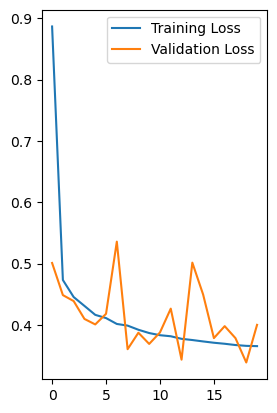

testing...


  0%|          | 0/253158 [00:00<?, ?it/s]

 Fold: 2/5 R2 = 71.94 , RMSE = 0.000338
Fold: 3 /5
training...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [1/20]: Train loss: 0.877760104801,        Valid loss: 0.562150061103
Saving model with loss 0.562150061103...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [2/20]: Train loss: 0.471442552197,        Valid loss: 0.465988680394
Saving model with loss 0.465988680394...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [3/20]: Train loss: 0.441634735247,        Valid loss: 0.417345868250
Saving model with loss 0.417345868250...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [4/20]: Train loss: 0.422264588305,        Valid loss: 0.402868358687
Saving model with loss 0.402868358687...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [5/20]: Train loss: 0.412892249396,        Valid loss: 0.420662904971


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [6/20]: Train loss: 0.403607981454,        Valid loss: 0.385731122205
Saving model with loss 0.385731122205...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [7/20]: Train loss: 0.396775318744,        Valid loss: 0.403798898463


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [8/20]: Train loss: 0.391333594972,        Valid loss: 0.393021981437


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [9/20]: Train loss: 0.385392105613,        Valid loss: 0.353310004987
Saving model with loss 0.353310004987...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [10/20]: Train loss: 0.383414440554,        Valid loss: 0.382487092129


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [11/20]: Train loss: 0.378227201600,        Valid loss: 0.380697418454


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [12/20]: Train loss: 0.374332752330,        Valid loss: 0.378071270808


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [13/20]: Train loss: 0.372149817713,        Valid loss: 0.385859638593


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [14/20]: Train loss: 0.370976330150,        Valid loss: 0.352610425659
Saving model with loss 0.352610425659...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [15/20]: Train loss: 0.369374462409,        Valid loss: 0.409859545485


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [16/20]: Train loss: 0.366491178708,        Valid loss: 0.410628901716


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [17/20]: Train loss: 0.364559734318,        Valid loss: 0.374508398586


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [18/20]: Train loss: 0.363980293711,        Valid loss: 0.390855759874


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [19/20]: Train loss: 0.362305797771,        Valid loss: 0.336494078737
Saving model with loss 0.336494078737...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [20/20]: Train loss: 0.362527681391,        Valid loss: 0.366948214854


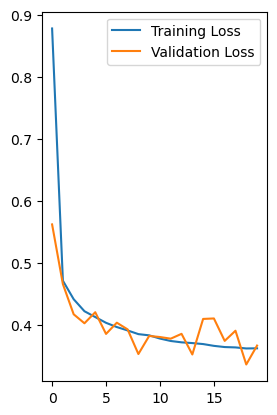

testing...


  0%|          | 0/253158 [00:00<?, ?it/s]

 Fold: 3/5 R2 = 72.46 , RMSE = 0.000335
Fold: 4 /5
training...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [1/20]: Train loss: 0.874892555225,        Valid loss: 0.464583281920
Saving model with loss 0.464583281920...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [2/20]: Train loss: 0.472404977798,        Valid loss: 0.408195865266
Saving model with loss 0.408195865266...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [3/20]: Train loss: 0.444435940987,        Valid loss: 0.397147830072
Saving model with loss 0.397147830072...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [4/20]: Train loss: 0.426518328800,        Valid loss: 0.385835557260
Saving model with loss 0.385835557260...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [5/20]: Train loss: 0.412898605326,        Valid loss: 0.383370679718
Saving model with loss 0.383370679718...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [6/20]: Train loss: 0.405807606340,        Valid loss: 0.388544594277


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [7/20]: Train loss: 0.400213137941,        Valid loss: 0.383755018192


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [8/20]: Train loss: 0.397214483129,        Valid loss: 0.379246438528
Saving model with loss 0.379246438528...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [9/20]: Train loss: 0.394212606450,        Valid loss: 0.371686078888
Saving model with loss 0.371686078888...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [10/20]: Train loss: 0.387307127935,        Valid loss: 0.412973245445


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [11/20]: Train loss: 0.386337618597,        Valid loss: 0.357608975474
Saving model with loss 0.357608975474...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [12/20]: Train loss: 0.383257623223,        Valid loss: 0.355327911919
Saving model with loss 0.355327911919...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [13/20]: Train loss: 0.380345536307,        Valid loss: 0.395482054152


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [14/20]: Train loss: 0.379934211858,        Valid loss: 0.379909931646


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [15/20]: Train loss: 0.375282809319,        Valid loss: 0.386196540442


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [16/20]: Train loss: 0.376402055173,        Valid loss: 0.441294531882


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [17/20]: Train loss: 0.373382360537,        Valid loss: 0.366951332221


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [18/20]: Train loss: 0.372068746877,        Valid loss: 0.344424955302
Saving model with loss 0.344424955302...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [19/20]: Train loss: 0.370703416329,        Valid loss: 0.352430097694


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [20/20]: Train loss: 0.369904241935,        Valid loss: 0.342267787002
Saving model with loss 0.342267787002...


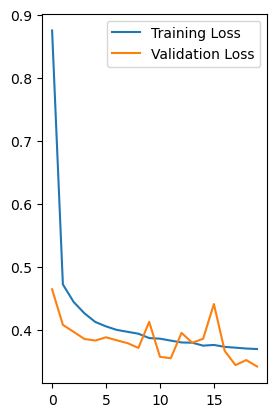

testing...


  0%|          | 0/253158 [00:00<?, ?it/s]

 Fold: 4/5 R2 = 71.09 , RMSE = 0.000344
Fold: 5 /5
training...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [1/20]: Train loss: 0.874640365233,        Valid loss: 0.502560621453
Saving model with loss 0.502560621453...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [2/20]: Train loss: 0.477118234026,        Valid loss: 0.451056339982
Saving model with loss 0.451056339982...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [3/20]: Train loss: 0.447715353479,        Valid loss: 0.434161674639
Saving model with loss 0.434161674639...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [4/20]: Train loss: 0.429639955155,        Valid loss: 0.422895593170
Saving model with loss 0.422895593170...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [5/20]: Train loss: 0.420139774759,        Valid loss: 0.455517702500


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [6/20]: Train loss: 0.412111508974,        Valid loss: 0.545596349667


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [7/20]: Train loss: 0.403737002522,        Valid loss: 0.385314123894
Saving model with loss 0.385314123894...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [8/20]: Train loss: 0.399844610920,        Valid loss: 0.378245124350
Saving model with loss 0.378245124350...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [9/20]: Train loss: 0.394099493737,        Valid loss: 0.408344143821


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [10/20]: Train loss: 0.388887060775,        Valid loss: 0.359069500254
Saving model with loss 0.359069500254...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [11/20]: Train loss: 0.384879434944,        Valid loss: 0.361091728250


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [12/20]: Train loss: 0.379907914947,        Valid loss: 0.349652007352
Saving model with loss 0.349652007352...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [13/20]: Train loss: 0.379813722444,        Valid loss: 0.370751339786


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [14/20]: Train loss: 0.377036188220,        Valid loss: 0.351385608411


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [15/20]: Train loss: 0.373524224465,        Valid loss: 0.356336311790


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [16/20]: Train loss: 0.370745217038,        Valid loss: 0.345019113158
Saving model with loss 0.345019113158...


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [17/20]: Train loss: 0.367705226609,        Valid loss: 0.400129986900


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [18/20]: Train loss: 0.367813162210,        Valid loss: 0.411191545047


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [19/20]: Train loss: 0.366676336573,        Valid loss: 0.345879441459


  0%|          | 0/28481 [00:00<?, ?it/s]

Epoch [20/20]: Train loss: 0.365382667355,        Valid loss: 0.340908150547
Saving model with loss 0.340908150547...


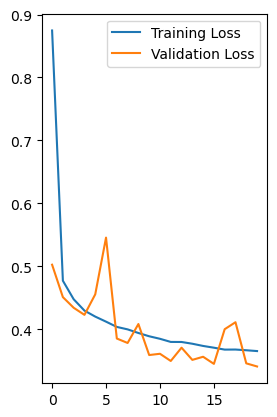

testing...


  0%|          | 0/253158 [00:00<?, ?it/s]

 Fold: 5/5 R2 = 71.13 , RMSE = 0.000343
list_train:[[0.8761885859337197, 0.474832078487285, 0.44615861473432483, 0.42737877786015555, 0.41786005154801314, 0.41299047675141143, 0.4054171262519599, 0.4000360511586924, 0.39492080955333014, 0.3867153382053241, 0.38235514388279807, 0.37975006513160864, 0.37629002443961057, 0.37539326510353266, 0.3722005183995819, 0.37127777547001184, 0.36921051245824066, 0.3686811588777778, 0.366484722811972, 0.36699540216783494], [0.8865502201998746, 0.47335713049048617, 0.4455447234356229, 0.43110498811038556, 0.41654598354710265, 0.41128686099466194, 0.4017142008657129, 0.399004887456003, 0.3922612562628174, 0.38688672058272416, 0.38337120417207954, 0.3816567707011264, 0.3774852466944926, 0.3755082896734011, 0.37321557993459087, 0.37108052656981966, 0.3694205137497325, 0.3673540226865346, 0.366005352280258, 0.3655657239085039], [0.8777601048010999, 0.4714425521973157, 0.44163473524721863, 0.4222645883049527, 0.41289224939604874, 0.4036079814544711, 0.396

In [30]:
# path = 'init.pth'
# torch.save(model.state_dict(), path)
config = {
    'seed': 9,
    'n_epochs': 20,     # Number of epoche(Interation)           
    'batch_size': 64, 
    'learning_rate': 0.001,              
    'early_stop': 6,    # If model has not improved for this many consecutive epoche, stop training/如果early_stop轮损失没有下降就停止训练.     
    'save_path': ['./models/model1.ckpt','./models/model2.ckpt','./models/model3.ckpt','./models/model4.ckpt','./models/model5.ckpt'],  # Model will be saved here.
}

list_train = []
list_valid = [] 
list_pred = []
y_test_r = torch.tensor(y_test[:,4])
for k, (train_index, valid_index) in enumerate(kf.split(x_rest)):
    print("Fold:", k+1,"/5")
    setup_seed(config['seed'])
    model = RePN_Model( [16, 64, 128], [[32, 32, 64], [64, 64, 128], [64, 96, 128]]).to(device) # 将模型和训练数据放在相同的存储位置(CPU/GPU)
    model =  copy.deepcopy(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) # Define Optimizer
    x_train, x_valid = x_rest[train_index], x_rest[valid_index]
    y_train, y_valid = y_rest[train_index], y_rest[valid_index]
    train_loader,valid_loader,test_loader = loader(x_train, y_train,x_valid, y_valid, x_test, y_test)
    #training-------------------------------------------------------------------------------------------------------
    print('training...')
    list_mean_train_loss, list_mean_valid_loss, best_loss = trainer(train_loader, valid_loader, model, config, device, optimizer )
    #print('list_mean_train_loss:{}'.format(list_mean_train_loss))
    #print('list_mean_valid_loss:{}'.format(list_mean_valid_loss))
    print_summary( list_mean_train_loss, list_mean_valid_loss)
    list_train.append(list_mean_train_loss)
    list_valid.append(list_mean_valid_loss)
    #test------------------------------------------------------------------------------------------------------------
    print('testing...')
    preds = test(test_loader, device, k, y_test_r)
    list_pred.append(preds)
    pass

preds = np.mean(list_pred, axis=0)
save_pred(preds, 'pred.csv')
print('list_train:{}'.format(list_train))
print('list_valid:{}'.format(list_valid))
RMSE = np.sqrt(mean_squared_error(y_test_r, preds))
R2 = r2_score(y_test_r, preds)
print(f" Final R2 = {R2*100:.2f} , RMSE = {RMSE:.6f}") 
#list_train = list(np.mean(list_train,axis=0))
#list_valid = list(np.mean(list_valid,axis=0))
#print_summary( list_train, list_valid)
#print('list_train:{}'.format(list_train))
#print('list_valid:{}'.format(list_valid))
    





### Calibration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 读取同一文件夹下的 pred.csv 文件
preds = pd.read_csv('pred.csv')
preds = preds['tested_positive']
#preds = [x[1:,:] for x in preds]
preds = np.array(preds)
#preds = [x[0] for x in preds]
print(preds)

['[5.9234e-05]' '[0.00138197]' '[0.00124242]' ... '[0.00044209]'
 '[0.00019049]' '[0.00055552]']


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
# simulated_data = {
#     'tested_positive': ['[5.9234e-05]', '[0.00138197]', '[0.00124242]', '[0.00037533]', '[-0.00028803]']
# }
preds = pd.read_csv('pred.csv')
# Create a simulated DataFrame

preds_df = pd.DataFrame(preds)

# Convert the string representation of list into actual numpy arrays
preds = preds_df['tested_positive'].apply(lambda x: np.array(ast.literal_eval(x)))

# Extract the first element from each numpy array
preds_values = preds.apply(lambda x: x[0])
preds_values = preds_values*1000
# Convert to a list
preds_list = preds_values.tolist()

preds_list

[0.059234,
 1.38197,
 1.2424199999999999,
 0.37533,
 -0.28003,
 0.36087,
 0.50208,
 0.34014,
 0.13368000000000002,
 0.12251,
 -0.077835095,
 0.52933,
 0.16190000000000002,
 0.021991017999999998,
 -0.10694000000000001,
 0.3839,
 0.40143,
 0.28567000000000004,
 0.21864,
 0.49478,
 0.40295000000000003,
 1.12284,
 0.26313,
 0.31933,
 0.23861,
 4.6178,
 0.32700999999999997,
 0.16452,
 0.009239464999999999,
 0.48997999999999997,
 1.25241,
 0.24291,
 0.30522,
 0.20798999999999998,
 0.17490999999999998,
 -0.28016,
 0.015305563999999999,
 0.34306000000000003,
 0.6621,
 0.00042426400000000004,
 -0.28121,
 0.47716000000000003,
 0.5887899999999999,
 0.23691,
 1.57574,
 0.22594999999999998,
 0.42423,
 0.19445,
 0.20374,
 0.29797999999999997,
 0.1487,
 0.68414,
 0.5048900000000001,
 0.43624,
 0.5420499999999999,
 0.29838,
 1.81898,
 0.39371,
 1.1816000000000002,
 1.23856,
 0.20247,
 0.28412,
 0.60843,
 0.21902,
 -0.17637999999999998,
 0.62383,
 0.0010999153,
 0.62718,
 0.6142,
 0.40102,
 0.391850000

<function matplotlib.pyplot.show(close=None, block=None)>

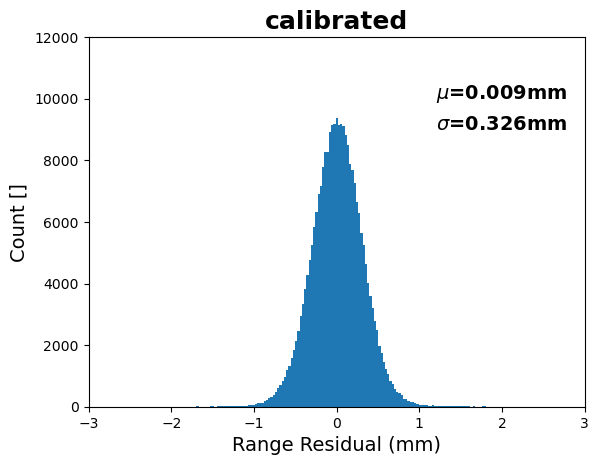

In [57]:
y_test_r = y_test[:,4]*1000
cali =  y_test_r - preds_list
plt.hist(cali, bins=1000)
mean = np.mean(cali)
std = np.std(cali)
plt.xlabel("Range Residual (mm)", fontsize=14)
plt.ylabel("Count []", fontsize=14)
plt.xlim((-3, 3))
plt.ylim((0, 12000))
#plt.xlim((-0.005, 0.01))
plt.title("calibrated", fontweight='bold', fontsize=18)
plt.text(1.2, 10000, r'$\mu$='+str(round(mean,3))+'mm', fontsize=14, fontweight='bold')
plt.text(1.2, 9000, r'$\sigma$='+str(round(std,3))+'mm', fontsize=14, fontweight='bold')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

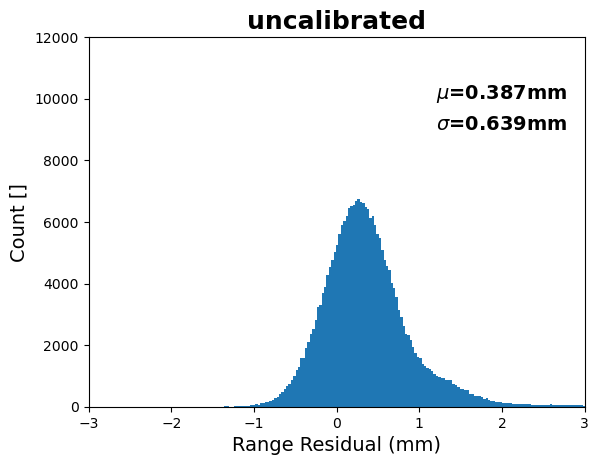

In [58]:

plt.hist(y_test_r, bins=1000)
mean = np.mean(y_test_r)
std = np.std(y_test_r)
plt.xlabel("Range Residual (mm)", fontsize=14)
plt.ylabel("Count []", fontsize=14)
plt.xlim((-3, 3))
plt.ylim((0, 12000))
plt.title("uncalibrated", fontweight='bold', fontsize=18)
plt.text(1.2, 10000, r'$\mu$='+str(round(mean,3))+'mm', fontsize=14, fontweight='bold')
plt.text(1.2, 9000, r'$\sigma$='+str(round(std,3))+'mm', fontsize=14, fontweight='bold')
plt.show

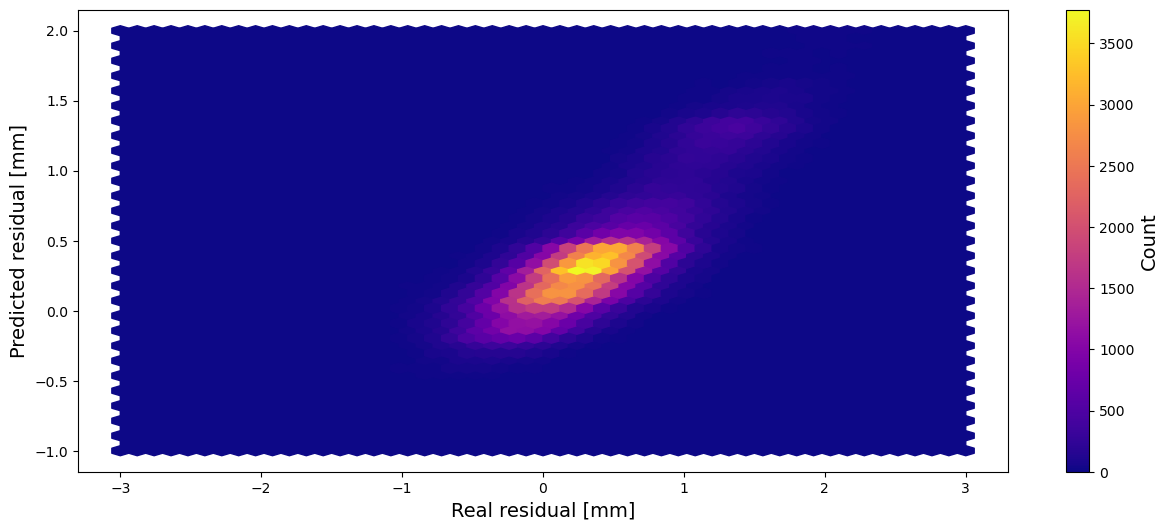

In [55]:


import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test_r and preds_list are numpy arrays containing the real and predicted residuals
y_test_r = np.array(y_test_r)
preds_list = np.array(preds_list)

# Create a hexbin plot
fig, ax = plt.subplots(figsize=(15, 6))
hb = ax.hexbin(y_test_r, preds_list, gridsize=50, cmap='plasma', extent=(-3, 3, -1, 2))

# Create a colorbar with a label
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Count', fontsize=14)

# Set labels and title with the appropriate font sizes
ax.set_xlabel('Real residual [mm]', fontsize=14)
ax.set_ylabel('Predicted residual [mm]', fontsize=14)
#ax.set_title('Hexbin plot of Real vs Predicted Residuals', fontsize=18,fontweight='bold')

plt.show()
